In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50V2
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import numpy as np
from sklearn.metrics import confusion_matrix
import sys

Vengono importate le librerie necessarie.

In [ ]:
imsize = 224
batch_size = 32


train_datagen = ImageDataGenerator(
        rotation_range=0.0,
        width_shift_range=0.2,
        height_shift_range=0.0,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.0,
        validation_split=0.5,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory('drive/MyDrive/Database/FRONT/Train', 
        target_size=(imsize, imsize),
        batch_size=batch_size, shuffle=True,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = train_datagen.flow_from_directory('drive/MyDrive/Database/FRONT/Train', 
        target_size=(imsize, imsize),
        batch_size=batch_size,
        class_mode='categorical', shuffle=True,
        subset='validation') 

test_generator = test_datagen.flow_from_directory('drive/MyDrive/Database/FRONT/Test',
        target_size=(imsize, imsize), batch_size=batch_size,
        class_mode=None, shuffle=False)

test_generator.reset()
input_shape = (imsize, imsize, 3)

Found 560 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


Vengono caricate le immagini da usare nella fase di training e di testing.
Ricordarsi di usare delle cartelle su cui è stato applicato il modulo **Drunk_FrontDetection**.

In [ ]:
x = keras.layers.Input(input_shape)
base_model = ResNet50V2(weights="imagenet",
                        input_shape=(224, 224, 3),
                        include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs, outputs)
_monitor = keras.callbacks.EarlyStopping(patience=60)
model.compile('Adam', loss='categorical_crossentropy', metrics=['acc', 'mean_absolute_percentage_error', 'AUC'])
model.summary()
checkpoint_filepath = 'drive/MyDrive/Modelli/ResNet50V2_100epoch_best_model.hdf5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        save_best_only=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 23,630,434
Trainable params: 65,634
Non-trainable params: 23,564,800
_________________________________________________________________


Il modello è stato creato.

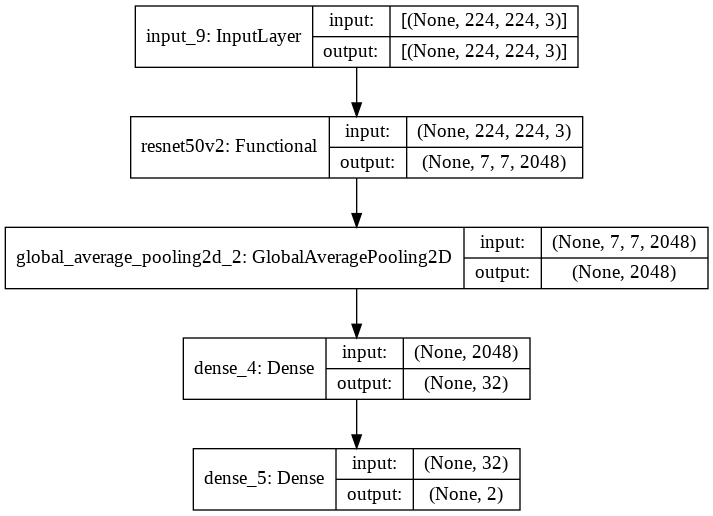

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True,  show_dtype=False, show_layer_names=True)

Il modello viene addestrato.

In [ ]:
hist = model.fit(
        train_generator, validation_data=validation_generator,
        epochs=100, verbose=2, validation_steps=validation_generator.samples // batch_size,
        callbacks=[model_checkpoint_callback, _monitor])

Epoch 1/100
18/18 - 13s - loss: 0.6672 - acc: 0.5875 - mean_absolute_percentage_error: 240072304.0000 - auc: 0.6296 - val_loss: 0.6821 - val_acc: 0.5977 - val_mean_absolute_percentage_error: 243803744.0000 - val_auc: 0.5895
Epoch 2/100
18/18 - 9s - loss: 0.6224 - acc: 0.6571 - mean_absolute_percentage_error: 226775248.0000 - auc: 0.7314 - val_loss: 0.6576 - val_acc: 0.6133 - val_mean_absolute_percentage_error: 236149824.0000 - val_auc: 0.6528
Epoch 3/100
18/18 - 10s - loss: 0.5992 - acc: 0.6857 - mean_absolute_percentage_error: 218214592.0000 - auc: 0.7556 - val_loss: 0.6495 - val_acc: 0.6250 - val_mean_absolute_percentage_error: 232601024.0000 - val_auc: 0.6669
Epoch 4/100
18/18 - 9s - loss: 0.5648 - acc: 0.7125 - mean_absolute_percentage_error: 205451200.0000 - auc: 0.7931 - val_loss: 0.6380 - val_acc: 0.6250 - val_mean_absolute_percentage_error: 227562128.0000 - val_auc: 0.6743
Epoch 5/100
18/18 - 10s - loss: 0.5446 - acc: 0.7339 - mean_absolute_percentage_error: 198669584.0000 - au

Per valutare le prestazioni del modello si crea un grafico che mostra l'andamento del valore **acc** e **val_acc** con l'avanzare delle epoche.

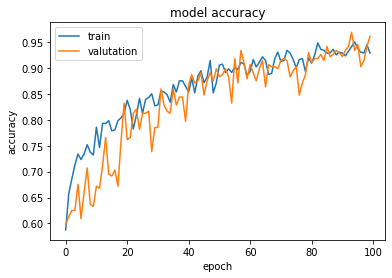

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valutation'], loc='upper left')
plt.show()

Per valutare le prestazioni del modello si crea un grafico che mostra l'andamento del valore **loss** e **val_loss** con l'avanzare delle epoche.

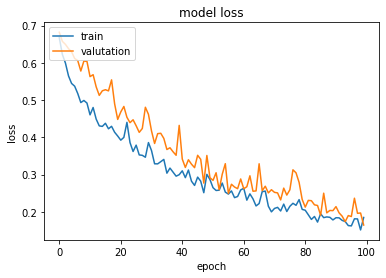

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valutation'], loc='upper left')
plt.show()

Usiamo la **matrice di confusione** per testare le prestazioni del nostro modello.

In [ ]:
probabilities = model.predict_generator(test_generator)
y_pred = np.argmax(probabilities, axis=1)
print (y_pred)

y_true=test_generator.classes
print(y_true)
print(confusion_matrix(y_true,y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[84 36]
 [22 98]]
